In [169]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name):
    v = numpy.loadtxt(file_name)

    u = numpy.array(v[:, 1:3])
    x = numpy.array(v[:, 3:5])

    dt= v[:, -1].mean()*0.001
    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t, dt

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x, wheel_diameter = 34.0, wheel_brace = 80.0):

    n_steps = x.shape[0]
    
    right_position= x[:, 1] 
    left_position = x[:, 0]

    #transform wheels traveled distance into robot frame
    distance = 0.25*(right_position + left_position)*wheel_diameter
    angle    = 0.5*(right_position - left_position)*wheel_diameter / wheel_brace
    
    #zero initial conditions
    distance = distance - distance[0]
    angle    = angle - angle[0]

    x_aug = numpy.zeros((n_steps, 2))
    x_aug[:, 0] = distance
    x_aug[:, 1] = angle

    vel = difference(x_aug[:, 0:2])
    x_aug = numpy.concatenate([x_aug, vel], axis=1)


    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()
    
    fig, axs = plt.subplots(4, 1, figsize=(8, 2*5))


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control left")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control right")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [m]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1], color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1], color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [rad]")
    axs[3].grid()

    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [170]:
#obtain model
u_result, x_result, t_result, dt = load_from_file("./data/run_4.log")


#normalise speed
speed_max = 1500.0*2.0*numpy.pi/60.0

u_result = u_result/speed_max


x_ref = state_augmentation(x_result.copy())

 


#identification
a_est, b_est = LibsControl.recursive_ls_identification(u_result, x_ref)
    
c_est = numpy.zeros((a_est.shape[0]//2, a_est.shape[0]))
for n in range(a_est.shape[0]//2):
    c_est[n][n] = 1.0


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")




#model symmetrization

x_flip = numpy.flip(x_result.copy(), axis=1)
u_flip = numpy.flip(u_result.copy(), axis=1)

x_flip = state_augmentation(x_flip)

#identification
a_est_flip, b_est_flip = LibsControl.recursive_ls_identification(u_flip, x_flip)

print("mat_a_flip = \n", a_est_flip, "\n\n")
print("mat_b_flip = \n", b_est_flip, "\n\n")

#one model rule them all
a_est = (a_est + a_est_flip)/2
b_est = (b_est + b_est_flip)/2



print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")


n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]


mat_a = 
 [[ 1.00019423e+00  1.69901023e-03  7.88128807e-03  9.92750442e-01]
 [-5.34291795e-07  1.00044579e+00  2.25035045e-03 -1.28712296e-01]
 [ 1.94229099e-04  1.69901023e-03  7.88128878e-03  9.92750434e-01]
 [-5.34289177e-07  4.45788793e-04  2.25034205e-03 -1.28710986e-01]] 


mat_b = 
 [[ 5.57799017  5.32966855]
 [-0.165848    0.13962474]
 [ 5.57799017  5.32966855]
 [-0.16584778  0.13962461]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]] 


mat_a_flip = 
 [[ 1.00019423e+00 -1.69901023e-03  7.88128807e-03 -9.92750442e-01]
 [ 5.34291795e-07  1.00044579e+00 -2.25035045e-03 -1.28712296e-01]
 [ 1.94229099e-04 -1.69901023e-03  7.88128878e-03 -9.92750434e-01]
 [ 5.34289177e-07  4.45788793e-04 -2.25034205e-03 -1.28710986e-01]] 


mat_b_flip = 
 [[ 5.32966855  5.57799017]
 [-0.13962474  0.165848  ]
 [ 5.32966855  5.57799017]
 [-0.13962461  0.16584778]] 


mat_a = 
 [[ 1.00019423e+00 -1.94072189e-17  7.88128807e-03  2.88657986e-15]
 [ 1.00055767e-20  1.00044579e+00  8.67361738e-19 -1.28712296

<Figure size 640x480 with 0 Axes>

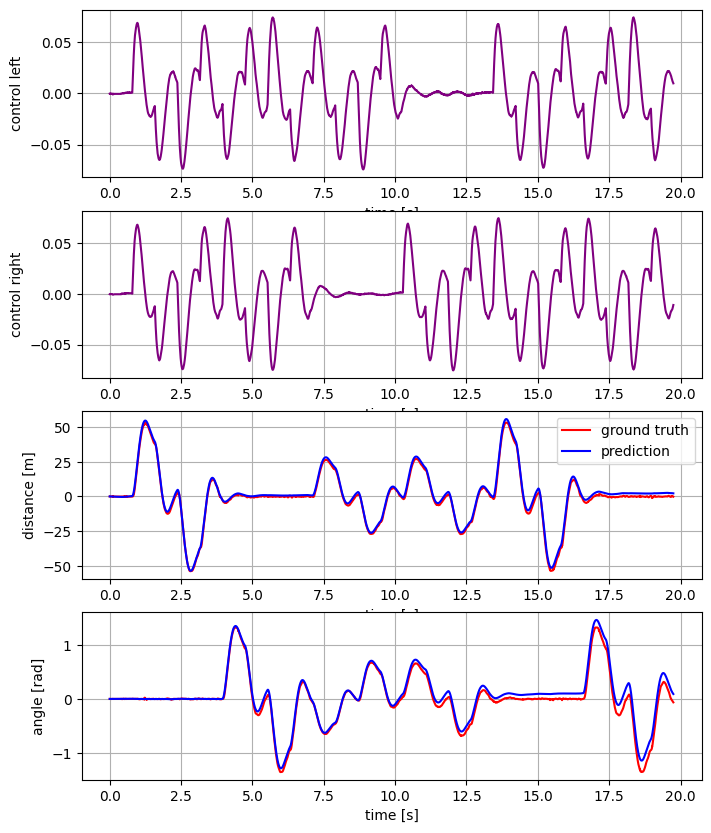

In [171]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, c_est)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)

#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 5000)


In [172]:
#controller synthetis

#create loss weighting matrices (diagonal)
q = numpy.diag([ 1.0, 1.0, 0.0, 0.0] )
r = numpy.diag( [1000000.0, 1000000.0]) 


#solve LQR controller
lqr = LibsControl.LQRDiscrete(a_est, b_est, q, r, 1.0)

print("controller")
print("k  = \n", lqr.k, "\n")
print("ki = \n", lqr.ki, "\n")
print("\n\n")

print("poles OL = ", numpy.linalg.eigvals(a_est))
print("poles CL = ", numpy.linalg.eigvals(a_est - b_est@lqr.k))



controller
k  = 
 [[ 1.21085202e-02 -7.44130071e-02  9.01446762e-05  8.41056581e-03]
 [ 1.21085202e-02  7.44130071e-02  9.01446762e-05 -8.41056581e-03]] 

ki = 
 [[ 0.00075268 -0.0007142   0.          0.        ]
 [ 0.00075268  0.0007142   0.          0.        ]] 




poles OL =  [ 1.00019577  0.00787975 -0.12866017  1.00039497]
poles CL =  [ 0.86706101  0.00795564  0.98025545 -0.1286826 ]


<Figure size 640x480 with 0 Axes>

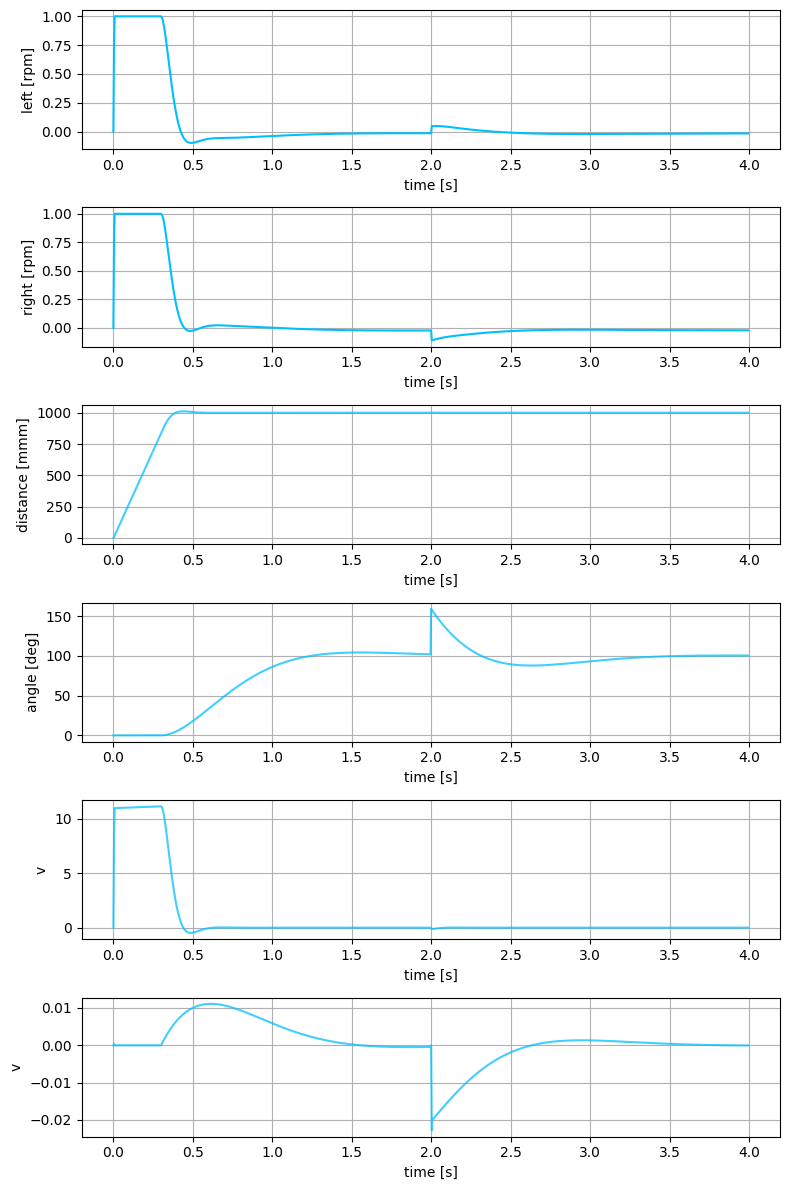

In [173]:
#process simulation

n_max = int(4.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T

#plant state
x     = numpy.zeros((a_est.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []



for n in range(n_max):

    #compute controller output
    u, integral_action = lqr.forward(xr, x, integral_action)

    #disturbance
    '''
    if n > n_max//2:
        u[0, :]+= 50
        u[1, :]+= 100
    '''

    if n == n_max//2:
        x[0, 0]+= 1 
        x[1, 0]+= 1
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

int_result = numpy.array(int_result)



#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result*speed_normalise, x_result, x_hat = None, file_name = "lqr_discrete_output.png", u_labels = ["left [rpm]", "right [rpm]"], x_labels = ["distance [mmm]", "angle [deg]", "v", "v"])




In [174]:
#print c-like arrays
print(matrix_to_c("k", lqr.k))
print(matrix_to_c("ki", lqr.ki))


float k[] = {
		0.012108521, -0.07441301, 9.014468e-05, 0.008410566, 
		0.012108521, 0.07441301, 9.014468e-05, -0.008410566 };

float ki[] = {
		0.0007526815, -0.00071419956, 0.0, 0.0, 
		0.0007526815, 0.00071419956, 0.0, 0.0 };

